In [1]:
import pandas
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime
import itertools
import time
import operator
%matplotlib inline

In [2]:
df = pandas.read_csv('BreadBasket_DMS.csv')
print(len(df), df['Transaction'].nunique(), df['Item'].nunique())
df.head()

21293 9531 95


,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam


### understand the date range of the dataset

In [3]:
print(df['Date'].min())
print(df['Date'].max())

2016-10-30
2017-04-09


In [4]:
## how many days are there between the datasets first and last date
print((datetime.strptime(df['Date'].max(), '%Y-%m-%d') - datetime.strptime(df['Date'].min(), '%Y-%m-%d')).days)

## how many days are there in the dataset
df['Date'].nunique()

161


159

###  explore the items sold

In [5]:
print(df['Item'].nunique())
df.groupby('Item').size().sort_values(ascending = False).head(10)

95


Item
Coffee           5471
Bread            3325
Tea              1435
Cake             1025
Pastry            856
NONE              786
Sandwich          771
Medialuna         616
Hot chocolate     590
Cookies           540
dtype: int64

#### remove NONE item

In [6]:
print(len(df))
df = df[df['Item']!='NONE']
print(len(df))

21293
20507


## create an undirected weighted graph with all the items that appear on the same transaction

* The nodes in the graph are all the unique items that were purchased from the bakery.
* There will be an undirected edge between item x and item y if x and y appear in the same transaction.
    * Hence, a transaction that has 3 items, x,y,z, in it will produce 3 edges: (x,y), (x,z), (y,z).
* The edge between x and y will be weighted according to the number of transaction that x and y appear in together.
* If a transaction has only iteam x in it,  there will be a self edge between x and x in the graph.

In [7]:
## produce a dataframe with a list of all the unique iteams for each transaction.

item_combinations = pandas.DataFrame({'items' : df.groupby('Transaction')['Item'].unique(),
                                     'num_items' : df.groupby('Transaction')['Item'].nunique() })
item_combinations.reset_index(inplace = True)

item_combinations.head()

,Transaction,items,num_items
0,1,[Bread],1
1,2,[Scandinavian],1
2,3,"[Hot chocolate, Jam, Cookies]",3
3,4,[Muffin],1
4,5,"[Coffee, Pastry, Bread]",3


{'boxes': [<matplotlib.lines.Line2D at 0x113580fd0>],
 'caps': [<matplotlib.lines.Line2D at 0x113589a20>,
 'fliers': [<matplotlib.lines.Line2D at 0x1135956d8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1135952b0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x113589160>,
  <matplotlib.lines.Line2D at 0x1135895f8>]}

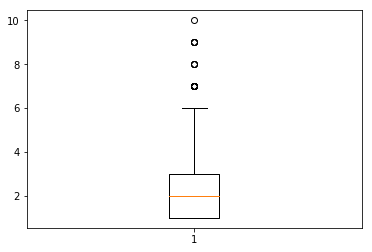

In [8]:
plt.boxplot(item_combinations['num_items'])

In [9]:
# function to take a list of items and a graph G and add all the appropriate edges to G

def add_edges_for_same_transaction(list, G):
    if len(list) == 1: ##if there is only one item in the transaction add a self-edge
        if G.has_edge(list[0], list[0]):
            G[list[0]][list[0]]['weight'] += 1 #if this edge already exists, just increase its weight by one
        else:
            G.add_edge(list[0], list[0], weight = 1) #othewise add the edge
        return G
    
    for couple in itertools.combinations(list, 2): #get all combinations of size 2 from each transaction
        if G.has_edge(couple[0], couple[1]):
            G[couple[0]][couple[1]]['weight'] += 1 
        else:
            G.add_edge(couple[0], couple[1], weight = 1) #the graph is undirected, so it doesn't matter which iteam comes first

    return G

In [10]:
# create the graph object and populate it according to item_combinations dataframe using the function above

## two ways of achieving the same thing.
## the for loop approach is much slower than the apply appraoch

start = time.time()
G = nx.Graph()
for i in range(len(item_combinations)):
    temp = item_combinations['items'][i]
    G = add_edges_for_same_transaction(temp, G)

print(G.number_of_nodes())
print(G.number_of_edges())
print(time.time() - start)

start = time.time()
G = nx.Graph()
G = item_combinations['items'].apply(lambda x: add_edges_for_same_transaction(x, G))[0]
print(G.number_of_nodes())
print(G.number_of_edges())
print(time.time() - start)

94
1112
0.2487640380859375
94
1112
0.05681896209716797


## explore the resulting graph

In [11]:
G = nx.Graph()
for i in range(len(item_combinations)):
    temp = item_combinations['items'][i]
    G = add_edges_for_same_transaction(temp, G)

print(G.number_of_nodes())
print(G.number_of_edges())

94
1112


### draw the Graph

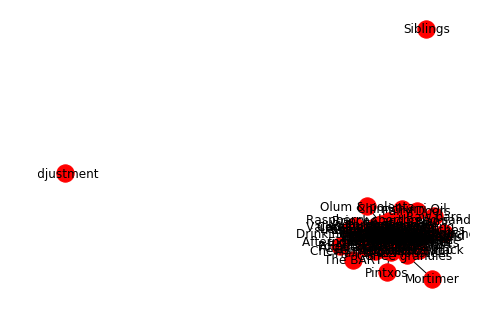

In [12]:
nx.draw(G, with_labels = True)

drawing the graph is not very helpful since everything is compressed.

### add a notion of distance to the graph

In [13]:
#this code take the weight of each edge and sets the attibute distance for that edge to be the reverse

g_distance_dict = {(e1, e2): 1 / weight for e1, e2, weight in G.edges(data='weight')}
nx.set_edge_attributes(G, g_distance_dict, 'distance')

The idea behind the above transformation is that the higher the weight between item x and y, the more frequently they appear together in transactions and hence the closer we want to consider them

### Degrees

In [14]:
#Top 10 highest degrees
sorted_degrees = sorted(dict(nx.degree(G)).items(), key=operator.itemgetter(1), reverse = True)
sorted_degrees[:10]

[('Coffee', 79),
 ('Bread', 75),
 ('Tea', 68),
 ('Cake', 64),
 ('Juice', 58),
 ('Hot chocolate', 57),
 ('Cookies', 56),
 ('Sandwich', 54),
 ('Brownie', 53),
 ('Muffin', 52)]

In [15]:
degrees = dict(nx.degree(G, weight = 'weight'))

## the following loop is to address the fact that nx.degress doublecounts the nodes that have a self edge.
## if the node coffee has 10 edges with itself, the function will count that as 20 because. 
# So I am taking whatever the function returns and I substract once the number of selfedges, if there are any.
for key in list(degrees.keys()):
    try:
        degrees[key] = degrees[key] - G[key][key]['weight']
        #print('done')
    except: #this node doesn't have any self edges
        continue

sorted_degrees_weight = sorted(degrees.items(), key=operator.itemgetter(1), reverse = True)
sorted_degrees_weight[:10]

[('Coffee', 7285),
 ('Bread', 4722),
 ('Tea', 2572),
 ('Cake', 1997),
 ('Pastry', 1424),
 ('Sandwich', 1404),
 ('Hot chocolate', 1211),
 ('Medialuna', 1107),
 ('Cookies', 1080),
 ('Juice', 973)]

### ratio of self degreee to overall degree

What percent of the degree of each node is edges towards itself (i.e., self edges)?
The smaller the number, it means that the item is less frequently purchased by itself.

In [31]:
key = 'Coffee'
#sorted_degrees_weight[0][1]
print(G[key][key]['weight']/sorted_degrees_weight[0][1])
key = 'Bread'
#sorted_degrees_weight[0][1]
print(G[key][key]['weight']/sorted_degrees_weight[0][1])
key = 'Tea'
#sorted_degrees_weight[0][1]
print(G[key][key]['weight']/sorted_degrees_weight[0][1])


0.163761153054221
0.1636238846945779
0.02786547700754976


In [32]:
self_edge_ratio = dict()

for i in range(len(sorted_degrees_weight)):
    key = sorted_degrees_weight[i][0]
    try:
        self_edge_ratio[key] = G[key][key]['weight']/(sorted_degrees_weight[i][1])
    except:
        self_edge_ratio[key] = 0 #this item doesnt have any edges with itself, hence no transactions that had only this item
sorted(dict(self_edge_ratio).items(), key=operator.itemgetter(1), reverse = True)

[('Adjustment', 1.0),
 ('Siblings', 1.0),
 ('Pintxos', 0.8333333333333334),
 ('Mortimer', 0.8),
 ("Valentine's card", 0.6666666666666666),
 ('Afternoon with the baker', 0.5166666666666667),
 ('Vegan Feast', 0.4166666666666667),
 ('Tshirt', 0.4),
 ('Farm House', 0.384321223709369),
 ('Christmas common', 0.3333333333333333),
 ('Baguette', 0.29767441860465116),
 ('Scandinavian', 0.28428927680798005),
 ('Argentina Night', 0.2727272727272727),
 ('Bread', 0.2524354087251165),
 ('Postcard', 0.25),
 ('Muesli', 0.23076923076923078),
 ('Coffee granules ', 0.2222222222222222),
 ('Fudge', 0.20161290322580644),
 ('Half slice Monster ', 0.18181818181818182),
 ('Dulce de Leche', 0.18181818181818182),
 ('Coffee', 0.163761153054221),
 ('Gingerbread syrup', 0.15384615384615385),
 ('Panatone', 0.15384615384615385),
 ('Jam', 0.1511627906976744),
 ('Focaccia', 0.13186813186813187),
 ('Coke', 0.12176165803108809),
 ('Eggs', 0.11538461538461539),
 ('Kids biscuit', 0.10526315789473684),
 ('Basket', 0.1),
 ('V

In [18]:
sorted_self_edge = sorted(self_edge_ratio.items(), key=operator.itemgetter(1), reverse = False)
print(sorted_self_edge[:10])
#self_edge_ratio['Coffee']

[('Gift voucher', 0), ('Lemon and coconut', 0), ('Tacos/Fajita', 0), ('Empanadas', 0), ('Crepes', 0), ('Chicken sand', 0), ('Fairy Doors', 0), ('Drinking chocolate spoons ', 0), ('Chocolates', 0), ('Raspberry shortbread sandwich', 0)]


### Explore the connectivity of the graph

In [19]:
#is the graph connected?
print(nx.is_connected(G))

for x in nx.connected_components(G):
    connected_component = list(x)
    break

False


### path centrality

In [20]:
## how many closests paths, is each node involved in?
dijkstra_paths = []

for nodes in list(itertools.combinations(connected_component, 2)):
    dijkstra_paths.append(nx.dijkstra_path(G, nodes[0], nodes[1], weight='distance'))

In [21]:
## now go through each short path, and count how many paths does each node appear in

num_occurences_in_path = dict()

for path in dijkstra_paths:
    for node in path:
        if node in num_occurences_in_path.keys():
            num_occurences_in_path[node] += 1
        else:
            num_occurences_in_path[node] = 1

In [33]:
len(dijkstra_paths)

4186

In [22]:
sorted(num_occurences_in_path.items(), key=operator.itemgetter(1), reverse = True)

[('Coffee', 3950),
 ('Bread', 1012),
 ('Tea', 529),
 ('Scandinavian', 190),
 ('Art Tray', 182),
 ('Coke', 181),
 ('Coffee granules ', 181),
 ('Cake', 178),
 ('Farm House', 168),
 ('Juice', 94),
 ('Fudge', 93),
 ('Tshirt', 92),
 ('Focaccia', 92),
 ('Half slice Monster ', 91),
 ('Lemon and coconut', 91),
 ('Tacos/Fajita', 91),
 ('Vegan Feast', 91),
 ('Sandwich', 91),
 ('Chicken Stew', 91),
 ('Baguette', 91),
 ('Empanadas', 91),
 ('Dulce de Leche', 91),
 ('Kids biscuit', 91),
 ('Victorian Sponge', 91),
 ('Crepes', 91),
 ('Spanish Brunch', 91),
 ('Toast', 91),
 ('Jam', 91),
 ('Chicken sand', 91),
 ('Fairy Doors', 91),
 ('Extra Salami or Feta', 91),
 ('Drinking chocolate spoons ', 91),
 ('Bakewell', 91),
 ('Gingerbread syrup', 91),
 ('Bacon', 91),
 ('Tiffin', 91),
 ('Keeping It Local', 91),
 ('Bowl Nic Pitt', 91),
 ('Muffin', 91),
 ('Gift voucher', 91),
 ('Hack the stack', 91),
 ('Duck egg', 91),
 ('Truffles', 91),
 ('Granola', 91),
 ('Muesli', 91),
 ('Mighty Protein', 91),
 ("Ella's Kitche

### eigenvector centrality

In [23]:
sorted(nx.eigenvector_centrality(G).items(), key=operator.itemgetter(1), reverse = True)

[('Coffee', 0.20035240490161663),
 ('Bread', 0.19626506319171166),
 ('Tea', 0.1887269472717235),
 ('Cake', 0.18741334122580403),
 ('Juice', 0.18222989362153802),
 ('Cookies', 0.18207421050461017),
 ('Hot chocolate', 0.17737556987985856),
 ('Sandwich', 0.17643312583724682),
 ('Brownie', 0.17491609339629405),
 ('Muffin', 0.1722782276556668),
 ('Pastry', 0.1720270364636767),
 ('Alfajores', 0.17167554444973915),
 ('Medialuna', 0.16740343285761758),
 ('Truffles', 0.16011447650003727),
 ('Farm House', 0.15964311639023424),
 ('Soup', 0.1586145013691743),
 ('Scone', 0.15338879662521623),
 ('Toast', 0.1528066958839212),
 ('Coke', 0.1503238985400949),
 ('Spanish Brunch', 0.14713208571629402),
 ('Fudge', 0.14628365790211365),
 ('Mineral water', 0.14555762790642643),
 ('Smoothies', 0.14467402739489946),
 ('Scandinavian', 0.14429072061359147),
 ('Chicken Stew', 0.1406888413987323),
 ('Salad', 0.13691445813431372),
 ('Jam', 0.13644733572102438),
 ('Frittata', 0.13266795650717267),
 ('The Nomad', 0.1

### betweeness centrality

In [24]:
sorted(nx.centrality.betweenness_centrality(G).items(), key=operator.itemgetter(1), reverse = True)

[('Coffee', 0.1391136368845654),
 ('Bread', 0.1352907278074832),
 ('Tea', 0.09386835259533435),
 ('Cake', 0.053890891403435635),
 ('Scandinavian', 0.03449598384641857),
 ('Coke', 0.0265177452337779),
 ('Hot chocolate', 0.02517043156923536),
 ('Juice', 0.024889371839491366),
 ('Farm House', 0.02468897159808774),
 ('Coffee granules ', 0.021037868162692847),
 ('Sandwich', 0.0186579674792157),
 ('Cookies', 0.0165804180377092),
 ('Brownie', 0.015591417221146408),
 ('Fudge', 0.014745970696623468),
 ('Muffin', 0.014522835037888066),
 ('Alfajores', 0.01368030550879383),
 ('Soup', 0.013457905271244387),
 ('Salad', 0.01141597692191226),
 ('Medialuna', 0.0105298979537606),
 ('Pastry', 0.010463927715915974),
 ('Jam', 0.009410615360954284),
 ('Focaccia', 0.007856846814138375),
 ('Art Tray', 0.007528369735336214),
 ('Truffles', 0.0065596753315364745),
 ('Extra Salami or Feta', 0.005761320262381643),
 ('Scone', 0.005402701659824912),
 ('Frittata', 0.0051403333876073),
 ('My-5 Fruit Shoot', 0.00414988

### closeness centrality

In [25]:
sorted(nx.centrality.closeness.closeness_centrality(G).items(), key=operator.itemgetter(1), reverse = True)

[('Coffee', 0.8480286738351255),
 ('Bread', 0.8094819159335288),
 ('Tea', 0.7610513739545998),
 ('Cake', 0.7420250896057348),
 ('Juice', 0.7011260689188045),
 ('Hot chocolate', 0.6956485215053764),
 ('Cookies', 0.6902558973076602),
 ('Sandwich', 0.6797176393334976),
 ('Brownie', 0.6745682632779407),
 ('Muffin', 0.6694963214487832),
 ('Alfajores', 0.6694963214487832),
 ('Pastry', 0.6645000802439416),
 ('Medialuna', 0.6547280202403541),
 ('Farm House', 0.649948983596264),
 ('Soup', 0.6452392083528129),
 ('Truffles', 0.6360215053763442),
 ('Scandinavian', 0.6360215053763442),
 ('Fudge', 0.6315107145580722),
 ('Coke', 0.6226783968719453),
 ('Scone', 0.6226783968719453),
 ('Toast', 0.6183542413381123),
 ('Mineral water', 0.614089729328884),
 ('Spanish Brunch', 0.6098836352923848),
 ('Jam', 0.6057347670250897),
 ('Salad', 0.6057347670250897),
 ('Chicken Stew', 0.6016419645451904),
 ('Smoothies', 0.6016419645451904),
 ('Frittata', 0.59760409901133),
 ('Art Tray', 0.5896888129317097),
 ('Jammi

In [26]:
sorted(nx.centrality.degree_centrality(G).items(), key=operator.itemgetter(1), reverse = True)

[('Coffee', 0.8494623655913979),
 ('Bread', 0.8064516129032259),
 ('Tea', 0.7311827956989247),
 ('Cake', 0.6881720430107527),
 ('Juice', 0.6236559139784946),
 ('Hot chocolate', 0.6129032258064516),
 ('Cookies', 0.6021505376344086),
 ('Sandwich', 0.5806451612903226),
 ('Brownie', 0.5698924731182796),
 ('Muffin', 0.5591397849462366),
 ('Alfajores', 0.5591397849462366),
 ('Pastry', 0.5483870967741936),
 ('Medialuna', 0.5268817204301076),
 ('Farm House', 0.5053763440860215),
 ('Soup', 0.5053763440860215),
 ('Scandinavian', 0.49462365591397855),
 ('Truffles', 0.4838709677419355),
 ('Fudge', 0.4731182795698925),
 ('Coke', 0.4623655913978495),
 ('Scone', 0.4516129032258065),
 ('Toast', 0.4408602150537635),
 ('Spanish Brunch', 0.4301075268817205),
 ('Mineral water', 0.4301075268817205),
 ('Jam', 0.41935483870967744),
 ('Smoothies', 0.40860215053763443),
 ('Chicken Stew', 0.39784946236559143),
 ('Salad', 0.39784946236559143),
 ('Frittata', 0.38709677419354843),
 ('Jammie Dodgers', 0.37634408602

In [27]:
sorted(nx.centrality.load_centrality(G).items(), key=operator.itemgetter(1), reverse = True)

[('Coffee', 0.1390545452291039),
 ('Bread', 0.1351598402022986),
 ('Tea', 0.09375998351711581),
 ('Cake', 0.05360788202482997),
 ('Scandinavian', 0.034348322677398006),
 ('Coke', 0.02654774674973964),
 ('Hot chocolate', 0.0251977565710928),
 ('Juice', 0.02482933773390197),
 ('Farm House', 0.02467641281890259),
 ('Coffee granules ', 0.021037868162692847),
 ('Sandwich', 0.01858477942171138),
 ('Cookies', 0.016540555892855364),
 ('Brownie', 0.015556437882977807),
 ('Fudge', 0.014751116000055735),
 ('Muffin', 0.014481703135784393),
 ('Alfajores', 0.01365670646172823),
 ('Soup', 0.013421893316752266),
 ('Salad', 0.011273716945628759),
 ('Medialuna', 0.01050055038308417),
 ('Pastry', 0.010445708458759527),
 ('Jam', 0.00941655728086934),
 ('Focaccia', 0.0079941430463877),
 ('Art Tray', 0.007572648812863963),
 ('Truffles', 0.006575218080443918),
 ('Extra Salami or Feta', 0.005785552009814667),
 ('Scone', 0.005391201901694068),
 ('Frittata', 0.005150348534325847),
 ('My-5 Fruit Shoot', 0.004253